# Fake News Detection: What NLP tools available can help us tackle this issue?

## Introduction

The rise of fake news and propaganda has sparked numerous research efforts to address the problem using machine learning. Some researchers concentrate on Deep Learning techniques, while others opt for a more hands-on approach. As stated in [this study](https://www.hindawi.com/journals/complexity/2021/5557784/), a numerous researches have proven the significance of the CNN and deep learning models for classification of fake news, however there is still a room for improvement. It is also found that [LIAR](https://paperswithcode.com/dataset/liar) dataset is one of the widely used benchmark dataset for the detection of fake news.

This research project concentrates mainly on the feature engineering. Our goal is to create features that can be leveraged for training neural networks, effectively bridging the gap between manual methods and automated Deep Learning techniques.

Before jumping to the code, let us import all the tools necessary for this project.

In [159]:
# Data storing and computations
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk import ngrams, word_tokenize, pos_tag
from nltk.stem import PorterStemmer
from string import punctuation
import spacy

# ML tools
from sklearn.preprocessing import label_binarize

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImblearnPipeline

# Misc
import re

In [160]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yuliana.romaniv/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yuliana.romaniv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yuliana.romaniv/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## 1. Data Acquisition

In this project we will be using [LIAR](https://paperswithcode.com/dataset/liar) dataset. We have downloaded the resources into the `dataset` folder, so now we can load the data into `pandas` data frame.

In [15]:
liar_df = pd.read_csv("dataset/train.tsv", sep='\t', header=None)

According to the documentation, the dataset has the following columns:

    Column 1: the ID of the statement ([ID].json).
    Column 2: the label.
    Column 3: the statement.
    Column 4: the subject(s).
    Column 5: the speaker.
    Column 6: the speaker's job title.
    Column 7: the state info.
    Column 8: the party affiliation.
    Column 9-13: the total credit history count, including the current statement.
    9: barely true counts.
    10: false counts.
    11: half true counts.
    12: mostly true counts.
    13: pants on fire counts.
    Column 14: the context (venue / location of the speech or statement).

We can define a `column_names` variable to store them and introduce them as headers into our data frame.

In [16]:
column_names = ['Statement ID', 'Label', 'Statement', 'Subject', 'Speaker', 'Speaker\'s job title', 'State', 'Party affiliation', 'Barely true', 'False', 'Half true', 'Mostly true', 'Pants on fire', 'Statement context']
liar_df.columns = column_names

liar_df.head()

,Statement ID,Label,Statement,Subject,Speaker,Speaker's job title,State,Party affiliation,Barely true,False,Half true,Mostly true,Pants on fire,Statement context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [ ]:
liar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Statement ID         10240 non-null  object 
 1   Label                10240 non-null  object 
 2   Statement            10240 non-null  object 
 3   Subject              10238 non-null  object 
 4   Speaker              10238 non-null  object 
 5   Speaker's job title  7342 non-null   object 
 6   State                8030 non-null   object 
 7   Party affiliation    10238 non-null  object 
 8   Barely true          10238 non-null  float64
 9   False                10238 non-null  float64
 10  Half true            10238 non-null  float64
 11  Mostly true          10238 non-null  float64
 12  Pants on fire        10238 non-null  float64
 13  Statement context    10138 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB


Before manipulating the data, let us make sure that we don't have any missing values that is important to us, like statements and scores. As seen in the `head()` output, there are some missing values in `Speaker's job title`, `State` and `Party affiliation` columns, but that is less important data for our analysis.

In [6]:
def check_column_values(df, columns_to_check):
    nan_check = df[columns_to_check].isna().any()
    empty_string_check = (df[columns_to_check] == '').any()
    none_check = pd.isna(df[columns_to_check]).any()
    
    result = {
        'NaN Check': nan_check,
        'Empty String Check': empty_string_check,
        'None Check': none_check
    }

    return result

In [ ]:
check_column_values(liar_df, ['Label', 'Statement', 'Subject', 'Barely true', 'False', 'Half true', 'Mostly true', 'Pants on fire'])

{'NaN Check': Label            False
 Statement        False
 Subject           True
 Barely true       True
 False             True
 Half true         True
 Mostly true       True
 Pants on fire     True
 dtype: bool,
 'Empty String Check': Label            False
 Statement        False
 Subject          False
 Barely true      False
 False            False
 Half true        False
 Mostly true      False
 Pants on fire    False
 dtype: bool,
 'None Check': Label            False
 Statement        False
 Subject           True
 Barely true       True
 False             True
 Half true         True
 Mostly true       True
 Pants on fire     True
 dtype: bool}

It looks like we do have missing values in numerous columns, let us explore them more.

In [ ]:
subj_na = liar_df[liar_df['Subject'].isna()]
subj_na.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, 2142 to 9375
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Statement ID         2 non-null      object 
 1   Label                2 non-null      object 
 2   Statement            2 non-null      object 
 3   Subject              0 non-null      object 
 4   Speaker              0 non-null      object 
 5   Speaker's job title  0 non-null      object 
 6   State                0 non-null      object 
 7   Party affiliation    0 non-null      object 
 8   Barely true          0 non-null      float64
 9   False                0 non-null      float64
 10  Half true            0 non-null      float64
 11  Mostly true          0 non-null      float64
 12  Pants on fire        0 non-null      float64
 13  Statement context    0 non-null      object 
dtypes: float64(5), object(9)
memory usage: 240.0+ bytes


In [ ]:
subj_na.loc[2142, 'Statement']

'The fact is that although we have had a president who is opposed to abortion over the last eight years, abortions have not gone down.\'\'\tabortion\tbarack-obama\tPresident\tIllinois\tdemocrat\t70\t71\t160\t163\t9\ta TV interview with megachurch pastor Rick Warren in Lake Forest, Calif.\n2724.json\ttrue\tMost of the jobs that we lost were lost before the economic policies we put in place had any effect.\teconomy,job-accomplishments,jobs,stimulus\tbarack-obama\tPresident\tIllinois\tdemocrat\t70\t71\t160\t163\t9\tan interview on The Daily Show with Jon Stewart"'

We do have all the information, however it wasn't parsed correctly. If we look into the raw dataset - here's how this particular row looks like:

`638.json	false	"The fact is that although we have had a president who is opposed to abortion over the last eight years, abortions have not gone down.''	abortion	barack-obama	President	Illinois	democrat	70	71	160	163	9	a TV interview with megachurch pastor Rick Warren in Lake Forest, Calif.`

The issue is with the incorrect quotation marks, which confused `pandas`. Let us try to fix that.

In [ ]:
result_list = re.split(r'(?<!\')\t', subj_na.loc[2142, 'Statement'])

# Remove any remaining single quotes around the first and last elements
result_list[0] = result_list[0].lstrip('\'')
result_list[-1] = result_list[-1].rstrip('\'')

print(result_list)

["The fact is that although we have had a president who is opposed to abortion over the last eight years, abortions have not gone down.''\tabortion", 'barack-obama', 'President', 'Illinois', 'democrat', '70', '71', '160', '163', '9', 'a TV interview with megachurch pastor Rick Warren in Lake Forest, Calif.\n2724.json', 'true', 'Most of the jobs that we lost were lost before the economic policies we put in place had any effect.', 'economy,job-accomplishments,jobs,stimulus', 'barack-obama', 'President', 'Illinois', 'democrat', '70', '71', '160', '163', '9', 'an interview on The Daily Show with Jon Stewart"']


Instead of cleaning the document line by line we could remove all the punctuation before feeding it to `pandas`. We will define two functions for that.

In [5]:
def remove_punctuation(text):
    words = word_tokenize(text)
    words_without_punct = [word for word in words if word not in punctuation]
    clean_text = ' '.join(words_without_punct)
    
    return clean_text

def process_tsv(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as f_in:
        with open(output_file, 'w', encoding='utf-8') as f_out:
            for line in f_in:
                fields = line.strip().split('\t')
                clean_fields = [remove_punctuation(field) for field in fields]
                f_out.write('\t'.join(clean_fields) + '\n')

Now let us try to process our train.tsv file.

In [ ]:
input_file = "dataset/train.tsv"
output_file = "dataset/train-cleaned.tsv"

process_tsv(input_file, output_file)

We can re-load the dataset into the data frame and see if it's any better after cleaning.

In [18]:
liar_df = pd.read_csv("dataset/train-cleaned.tsv", sep='\t', header=None)
liar_df.columns = column_names
liar_df.head()

,Statement ID,Label,Statement,Subject,Speaker,Speaker's job title,State,Party affiliation,Barely true,False,Half true,Mostly true,Pants on fire,Statement context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0,0,0,a mailer
1,10540.json,half-true,When did the decline of coal start It started ...,energy history job-accomplishments,scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech
2,324.json,mostly-true,Hillary Clinton agrees with John McCain `` by ...,foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7,19,3,5,44,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,economy jobs,charlie-crist,NaN,Florida,democrat,15,9,20,19,2,an interview on CNN


Let us check column values and the problematic row we had before.

In [ ]:
liar_df.loc[2154]

Statement ID                                                    638.json
Label                                                              false
Statement              `` The fact is that although we have had a pre...
Subject                                                         abortion
Speaker                                                     barack-obama
Speaker's job title                                            President
State                                                           Illinois
Party affiliation                                               democrat
Barely true                                                           70
False                                                                 71
Half true                                                            160
Mostly true                                                          163
Pants on fire                                                          9
Statement context      a TV interview with megachur

In [ ]:
check_column_values(liar_df, ['Label', 'Statement', 'Subject', 'Barely true', 'False', 'Half true', 'Mostly true', 'Pants on fire'])

{'NaN Check': Label            False
 Statement        False
 Subject          False
 Barely true      False
 False            False
 Half true        False
 Mostly true      False
 Pants on fire    False
 dtype: bool,
 'Empty String Check': Label            False
 Statement        False
 Subject          False
 Barely true      False
 False            False
 Half true        False
 Mostly true      False
 Pants on fire    False
 dtype: bool,
 'None Check': Label            False
 Statement        False
 Subject          False
 Barely true      False
 False            False
 Half true        False
 Mostly true      False
 Pants on fire    False
 dtype: bool}

In [ ]:
subj_na = liar_df[liar_df['Subject'].isna()]
subj_na.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Statement ID         0 non-null      object
 1   Label                0 non-null      object
 2   Statement            0 non-null      object
 3   Subject              0 non-null      object
 4   Speaker              0 non-null      object
 5   Speaker's job title  0 non-null      object
 6   State                0 non-null      object
 7   Party affiliation    0 non-null      object
 8   Barely true          0 non-null      int64 
 9   False                0 non-null      int64 
 10  Half true            0 non-null      int64 
 11  Mostly true          0 non-null      int64 
 12  Pants on fire        0 non-null      int64 
 13  Statement context    0 non-null      object
dtypes: int64(5), object(9)
memory usage: 0.0+ bytes


Looks like we have all the data we need, however, there are still small artifacts left, like in the row 2154 we have redundant `` marks. We will address this issue in the Text processing section. For now, let us save the dataset in csv format with column names.

In [19]:
liar_df.to_csv("dataset/train-cleaned.csv")

Let us cleanup and save test and validation sets as well.

In [8]:
process_tsv("dataset/test.tsv", "dataset/test-cleaned.tsv")
process_tsv("dataset/valid.tsv", "dataset/valid-cleaned.tsv")

In [11]:
liar_df_test = pd.read_csv("dataset/test-cleaned.tsv", sep='\t', header=None)
liar_df_val = pd.read_csv("dataset/valid-cleaned.tsv", sep='\t', header=None)

liar_df_test.columns = column_names
liar_df_val.columns = column_names

In [12]:
check_column_values(liar_df_test, ['Label', 'Statement', 'Subject', 'Barely true', 'False', 'Half true', 'Mostly true', 'Pants on fire'])

{'NaN Check': Label            False
 Statement        False
 Subject          False
 Barely true      False
 False            False
 Half true        False
 Mostly true      False
 Pants on fire    False
 dtype: bool,
 'Empty String Check': Label            False
 Statement        False
 Subject          False
 Barely true      False
 False            False
 Half true        False
 Mostly true      False
 Pants on fire    False
 dtype: bool,
 'None Check': Label            False
 Statement        False
 Subject          False
 Barely true      False
 False            False
 Half true        False
 Mostly true      False
 Pants on fire    False
 dtype: bool}

In [13]:
check_column_values(liar_df_val, ['Label', 'Statement', 'Subject', 'Barely true', 'False', 'Half true', 'Mostly true', 'Pants on fire'])

{'NaN Check': Label            False
 Statement        False
 Subject          False
 Barely true      False
 False            False
 Half true        False
 Mostly true      False
 Pants on fire    False
 dtype: bool,
 'Empty String Check': Label            False
 Statement        False
 Subject          False
 Barely true      False
 False            False
 Half true        False
 Mostly true      False
 Pants on fire    False
 dtype: bool,
 'None Check': Label            False
 Statement        False
 Subject          False
 Barely true      False
 False            False
 Half true        False
 Mostly true      False
 Pants on fire    False
 dtype: bool}

In [14]:
liar_df_test.to_csv("dataset/test-cleaned.csv")
liar_df_val.to_csv("dataset/valid-cleaned.csv")

## 2. Simple Data Exploratory Analysis

In [ ]:
# Reload liar_df
# liar_df = pd.read_csv("dataset/train-cleaned.csv")

Before diving into feature extraction and model training, it's crucial to start with exploratory data analysis (EDA). EDA helps us get familiar with the dataset's characteristics, ensuring we make informed decisions later on. First of all, we'll look at the balance of the labels we have in our dataset. If some categories are much more common than others, our model might end up biased, good at recognizing the common ones and bad at spotting the rare ones. After labels, we'll check out the text itself. How long are the pieces? Are fake news articles longer or shorter than true ones, or is there no simple pattern? The visualizations below will provide us with some answers.

First of all, tet us explore what labels we have in our dataset.

In [ ]:
labels = liar_df['Label'].unique()
print(labels)

['false' 'half-true' 'mostly-true' 'true' 'barely-true' 'pants-fire']


We will build a couple of plots to visualize the distribution of text across the categories, word count distribution and word count by category.

In [ ]:
def plot_category_distribution(df, category_column):
    """
    Plots the distribution of texts across different categories.

    Parameters:
    - df: pandas DataFrame containing the dataset.
    - category_column: the name of the column containing the category labels.
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(y=category_column, data=df, order = df[category_column].value_counts().index)
    plt.title('Distribution of Text Across Categories')
    plt.xlabel('Number of Texts')
    plt.ylabel('Categories')
    plt.show()

def plot_word_count_distribution(df, text_column):
    """
    Plots the distribution of word counts in the texts.

    Parameters:
    - df: pandas DataFrame containing the dataset.
    - text_column: the name of the column containing the text data.
    """
    df['word_count'] = df[text_column].apply(lambda x: len(str(x).split()))
    
    plt.figure(figsize=(12, 6))
    sns.histplot(df['word_count'], bins=50, kde=True)
    plt.title('Word Count Distribution in Texts')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.show()

def plot_word_count_by_category(df, text_column, category_column):
    """
    Plots the distribution of word counts in texts across different categories.

    Parameters:
    - df: pandas DataFrame containing the dataset.
    - text_column: the name of the column containing the text data.
    - category_column: the name of the column containing the category labels.
    """
    df['word_count'] = df[text_column].apply(lambda x: len(str(x).split()))
    
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='word_count', y=category_column, data=df)
    plt.title('Word Count Distribution by Category')
    plt.xlabel('Word Count')
    plt.ylabel('Category')
    plt.show()


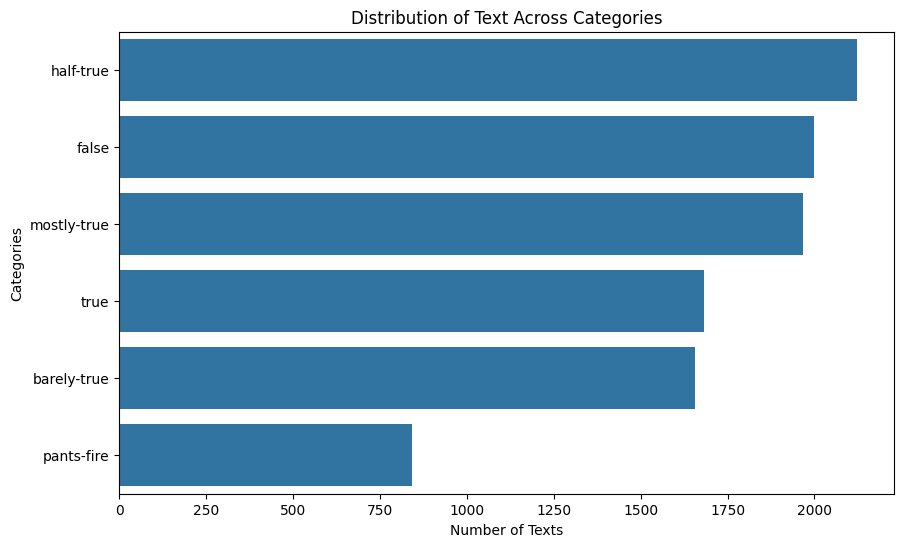

In [ ]:
plot_category_distribution(liar_df, "Label")

Based on the plot above, we can make the following observations:

1. **Category Imbalance**: The first observation is that there is a noticeable imbalance in the dataset across the different truthfulness categories. This is evident by the varying bar lengths, indicating the number of texts in each category.

2. **Most Common Categories**: The categories "half-true" and "mostly-true" have the highest number of texts, which suggests that the dataset contains a significant number of claims that are not entirely false or true but fall somewhere in between.

3. **Least Common Category**: The "pants-fire" category, which likely represents the most extreme level of falsehood, has the fewest texts. This could indicate that outright fabrications or extreme falsehoods are less common in the dataset, or possibly that they are less frequently identified and labeled as such.

4. **Potential Bias in Training**: Given the imbalance, a machine learning model trained on this dataset may develop a bias toward the more frequently occurring categories. It's important to consider techniques like oversampling, undersampling, or synthetic data generation to address this imbalance.

5. **Labeling Considerations**: The distribution suggests that labeling news as "true" or "false" might not be straightforward and that there are degrees of truthfulness. This complexity could present a challenge for a model's ability to discern nuances.

6. **Model Performance Implications**: The imbalance might affect the model performance differently across categories. For instance, the model might be less accurate for categories with fewer samples, like "pants-fire" and "barely-true".

7. **Data Collection and Curation**: The distribution may reflect the nature of the data collection and curation processes. It might be worthwhile to investigate why some categories have more examples than others. Is it due to the nature of news circulation, the methodology of data collection, or some other factors?

This plot highlights the need to consider the distribution of categories in model training and evaluation. It suggests that some categories of truthfulness are more commonly represented in the dataset, which could influence both the training process and the final performance of a machine learning model. It also raises questions about the nature of the data collection process and the potential need for data augmentation strategies to address category imbalance.

Now let us have a look at the word count distribution.

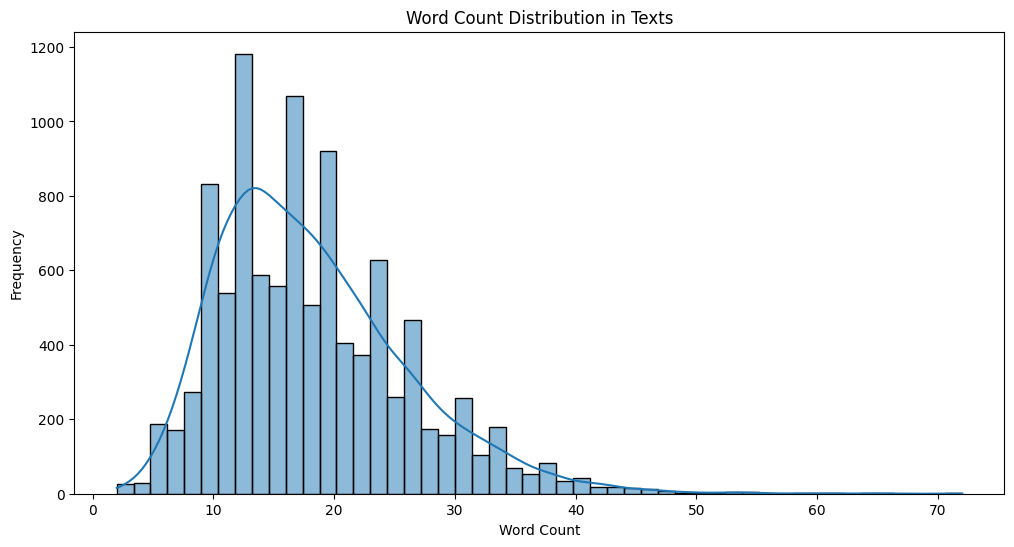

In [ ]:
plot_word_count_distribution(liar_df, "Statement")

The "Word Count Distribution in Texts" plot displays the frequency of texts with a given word count, and we can interpret the following:

1. **Most Common Word Count**: The majority of texts have word counts in the range of approximately 10 to 20 words. This peak suggests that the dataset largely consists of short statements or claims, which is typical for datasets comprised of headlines or short excerpts.

2. **Skewness**: The distribution is right-skewed, meaning there are fewer texts with a very high word count. This indicates that while most of the news items are concise, there are some that are considerably longer.

3. **Potential Outliers**: The tail of the distribution, where the word count is above 40, suggests there are potential outliers in the dataset. These could be longer articles or detailed statements.

4. **Text Length Considerations for ML Models**: Short texts may not provide enough context for certain machine learning models to accurately classify them, and longer texts could introduce noise. It's important to consider the impact of text length when designing features and choosing or training models.

5. **Preprocessing and Feature Engineering**: The skewness in word count might motivate different text preprocessing strategies. For example, padding might be necessary for models that expect input of a uniform length, or truncation might be applied to very long texts to maintain computational efficiency.

6. **Dataset Representation**: The word count distribution can also inform about the representativeness of the dataset. If the dataset is intended to represent a variety of news items, the model might be biased towards understanding and classifying shorter texts better than longer ones.

In conclusion, this plot suggests that any machine learning model we develop will need to handle a wide range of text lengths, with a focus on shorter texts due to their prevalence in the dataset. We might also need to consider special treatment for the longer texts to ensure that they are not treated as outliers by the model. Additionally, the skewness of the distribution could affect the model's ability to generalize across texts of varying lengths.

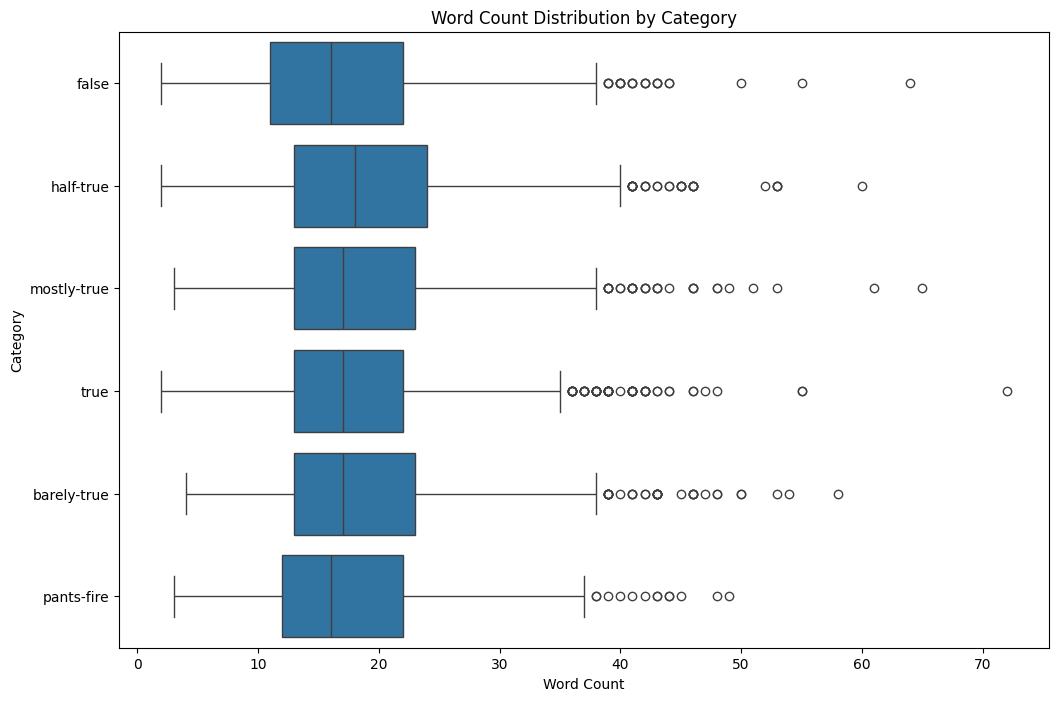

In [ ]:
plot_word_count_by_category(liar_df, "Statement", "Label")

The "Word Count Distribution by Category" plot can tell us the following:

1. **Central Tendency and Spread**: Each box plot shows the median word count (the line inside the box), the interquartile range (the box itself), and the range (the "whiskers" extending from the box). This provides a clear view of the central tendency and variability within each category.

2. **Consistency Across Categories**: The median word counts across categories appear to be somewhat consistent, suggesting that the average length of text does not vary dramatically between different truthfulness categories.

3. **Outliers**: There are a number of outliers in each category, represented by the dots outside the whiskers. These indicate texts that are significantly longer than the majority within their respective categories.

4. **Comparison of Extremes**: The "pants-fire" category (which represents a clear falsehood) does not show a significantly different word count distribution from the other categories, indicating that the length of a statement or article is not necessarily an indicator of its truthfulness.

5. **Model Feature Engineering**: When engineering features for the machine learning model, this plot suggests that the word count feature might not be a strong discriminator on its own between truthfulness categories. However, it may still provide useful information when combined with other features.

While there is variation in text length within each category, the central tendency is quite consistent across categories. Outliers are present in all categories, which is an important consideration for model training. The word count alone may not be a strong feature for predicting truthfulness, but it could be part of a suite of features that, when combined, contribute to a more accurate model.

This preliminary exploratory data analysis has provided us with valuable insights into the structure and composition of the dataset, which is critical for developing an effective machine learning model for classifying news as fake or real. Through visual examination of the data, we have uncovered several potential caveats that need to be addressed during the data preparation phase.

Firstly, the class imbalance highlighted by the category distribution plot is a key concern. It has shed light on the skewed nature of the dataset, with certain truthfulness categories being overrepresented and others underrepresented. This imbalance can lead to biased model predictions, and we will need strategies like resampling or using class weights during model training to ensure each category is appropriately represented.

The word count distribution analysis has revealed the variance in the length of texts across the dataset. The predominance of shorter texts and the presence of outliers suggest that the predictive model will need to handle a wide range of input lengths. This influences preprocessing decisions, such as whether to pad shorter texts or truncate longer ones, and it also has implications for feature engineering, particularly in the choice of using word or character n-grams.

Let us now proceed with the next step - text processing.

## 3. Data Preprocessing

In [4]:
# Reload liar_df
# liar_df = pd.read_csv("dataset/train-cleaned.csv")

Now that we know how the data looks like - we can proceed with the next steps. We will employ the default NLP technics to cleanup our text:

1. **Tokenization**: refers to breaking the unstructured text into pieces of information that can be considered as discrete elements - tokens.
   
2. **Punctuation removal**: there are cases where punctuation can indicate some interesting features in the text, but in the context of our research it is not necessary. 
   
3. **Lower case**: to avoid having the same words written in different cases counted as separate words it is a good practice to normalize the case throughout the entire text.
   
4. **Numbers removal**: we will remove all the numbers from the text.
   
5. **Stop Words Removal**: since a lot of words are not carrying significant meaning in the sentence - they can be considered as noise and removed. Sometimes it is a good idea to extend the list of stop words, however, in our case the data describes very different events, so we will use the standard list + a couple of generic words that can be very common: 'say', 'and', 'tell'.
   
6. **Stemming**: it is a process of reducing the words to its root. The main purpose of stemming is to reduce the frequency of derived words.

In [21]:
additional_stop_words = ["say", "tell", "have", "be", "should", "would", "it", "and"]

We already have `word_tokenize` and `remove_punctuation` functions, let us define the missing functions.

In [22]:
stemmer = PorterStemmer()

def convert_lower_case(data):
    return [word.lower() for word in data]

def remove_numbers(data):
    new_data = []
    for word in data:
        # Remove all digits from the word
        word_without_digits = re.sub(r'\d+', '', word)
        new_data.append(word_without_digits)
    return new_data


def remove_stop_words(data, additional_stop_words=None):
    stop_words = set(stopwords.words('english'))

    if additional_stop_words:
        stop_words.update(additional_stop_words)

    return [word for word in data if word not in stop_words]

def stemming(data):
    return [stemmer.stem(word) for word in data]

Our processing pipeline now looks like this:

In [23]:
def preprocess(data):
    data = word_tokenize(data)
    data = convert_lower_case(data)
    data = remove_numbers(data)
    data = stemming(data)
    data = remove_stop_words(data, additional_stop_words)

    return remove_punctuation(" ".join(data))

Let us try to process a piece of text to make sure we didn't miss anything.

In [49]:
liar_df.head()

,Unnamed: 0,Statement ID,Label,Statement,Subject,Speaker,Speaker's job title,State,Party affiliation,Barely true,False,Half true,Mostly true,Pants on fire,Statement context
0,0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0,0,0,a mailer
1,1,10540.json,half-true,When did the decline of coal start It started ...,energy history job-accomplishments,scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech
2,2,324.json,mostly-true,Hillary Clinton agrees with John McCain `` by ...,foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver
3,3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7,19,3,5,44,a news release
4,4,9028.json,half-true,The economic turnaround started at the end of ...,economy jobs,charlie-crist,NaN,Florida,democrat,15,9,20,19,2,an interview on CNN


In [12]:
liar_df.iloc[23]["Statement"]

'Says Scott Walker favors cutting up to 350,000 families and children off health care'

In [47]:
preprocess(liar_df.iloc[23]["Statement"])

'scott walker favor cut famili children health care'

Let us also define a simple function for text cleanup without tokenization and stemming, as it may be useful in some feature engineering steps later on.

In [51]:
def get_clean_text(input_text):
  # Remove '\n' and excessive whitespaces
  cleaned_text = ' '.join(input_text.split())
  # Remove square brackets
  cleaned_text = re.sub(r'\[|\]', '', cleaned_text)
  # Remove different double and single quotes
  cleaned_text = cleaned_text.replace("'", "").replace('"', '').replace("”", "").replace("“", "").replace("`", "")

  return cleaned_text

In [54]:
liar_df.iloc[2]["Statement"]

"Hillary Clinton agrees with John McCain `` by voting to give George Bush the benefit of the doubt on Iran ''"

In [53]:
get_clean_text(liar_df.iloc[2]["Statement"])

'Hillary Clinton agrees with John McCain  by voting to give George Bush the benefit of the doubt on Iran '

Everything seems to be working correctly. Now we can move on to the next step - Feature engineering.

## 4. Feature Engineering

There are many different options and variations of which features to extract from the dataset, how to reduce dimensionality to optimize ML model training, however for the scope of this project we will focus on just few of them. Since our task is a text classification task - we will be experimenting with TF-IDF, N-grams and NER.

In [ ]:
# Reload liar_df
# liar_df = pd.read_csv("dataset/train-cleaned.csv")

### 4.1 TF-IDF
`TF-IDF` stands for "text frequency / inverse document frequency" and it is useful for determining the importance of a word in a document relative to a collection of documents. It helps identify significant terms in a document, which can then be used for classification or similarity scoring. Fake news often contains certain distinctive terms or phrases that can be detected using TF-IDF. For this task we will be using `TfidfVectorizer`.

We will create and instance of the vectorizer and define some helper function at the beginning as well, so we can use them later on. The `TfidfVectorizer` has a lot of useful functionality that we need:
- it can account for the stopwords
- it ignores words that occur with a certain frequency (thus they are most probably not useful - like "This", "and" etc)
- it transforms the text into a vector that can be used later in ML model training

In [57]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5)

In [58]:
def extract_feature_scores(vectorizer, tfidf_matrix):
    """
    Extract feature scores from a TF-IDF matrix.

    Parameters:
    - vectorizer: TfidfVectorizer object, already fitted to the data.
    - tfidf_matrix: The TF-IDF matrix for the dataset, obtained from vectorizer.transform().

    Returns:
    - dict: A dictionary of feature names and their corresponding summed TF-IDF scores.
    """
    # Sum the TF-IDF scores for each feature
    scores = np.sum(tfidf_matrix, axis=0).A1
    feature_names = vectorizer.get_feature_names_out()
    feature_scores = dict(zip(feature_names, scores))
    
    return feature_scores

def plot_top_features(feature_scores, top_n=10, category_name='Category'):
    # Sort features by score and get the top n features and their scores
    sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    features, scores = zip(*sorted_features)
    
    y_pos = np.arange(len(features))
    
    plt.figure(figsize=(10, 8))
    plt.barh(y_pos, scores, align='center', color='skyblue')
    plt.yticks(y_pos, features)
    plt.xlabel('TF-IDF Score')
    plt.title(f'Top Features in {category_name}')
    plt.gca().invert_yaxis()  # Reverse the plot so the highest scores are on top
    plt.show()

Let us create separate data frames for each category.

In [59]:
false_df = liar_df[liar_df['Label'] == 'false']
half_true_df = liar_df[liar_df['Label'] == 'half-true']
mostly_true_df = liar_df[liar_df['Label'] == 'mostly-true']
pants_on_fire_df = liar_df[liar_df['Label'] == 'pants-fire']
true_df = liar_df[liar_df['Label'] == 'true']
barely_true_df = liar_df[liar_df['Label'] == 'barely-true']

In [60]:
false_text_processed = false_df['Statement'].apply(preprocess)
half_true_text_processed = half_true_df['Statement'].apply(preprocess)
mostly_true_text_processed = mostly_true_df['Statement'].apply(preprocess)
pants_on_fire_text_processed = pants_on_fire_df['Statement'].apply(preprocess)
true_text_processed = true_df['Statement'].apply(preprocess)
barely_true_text_processed = barely_true_df['Statement'].apply(preprocess)

A common approach is to fit the `TfidfVectorizer` on the entire dataset to learn a universal vocabulary and IDF scores, and then transform individual category subsets using the same vectorizer. Just like we did with the categories separately, let us process all the texts and save them into a single variable.

In [61]:
liar_df_text_processed = liar_df['Statement'].apply(preprocess)

Now we can fit the vectorizer on all texts and then transform subsets without a need to re-fit. This way, all our TF-IDF matrices will be in the same feature space, enabling us to train models or perform analyses consistently across different categories.

In [62]:
liar_df_tfidf_matrix = tfidf_vectorizer.fit_transform(liar_df_text_processed.tolist())

false_tfidf_matrix = tfidf_vectorizer.transform(false_text_processed.tolist())
half_true_tfidf_matrix = tfidf_vectorizer.transform(half_true_text_processed.tolist())
mostly_true_tfidf_matrix = tfidf_vectorizer.transform(mostly_true_text_processed.tolist())
pants_on_fire_tfidf_matrix = tfidf_vectorizer.transform(pants_on_fire_text_processed.tolist())
true_tfidf_matrix = tfidf_vectorizer.transform(true_text_processed.tolist())
barely_true_tfidf_matrix = tfidf_vectorizer.transform(barely_true_text_processed.tolist())

Now that we have our matrices, let's proceed with feature analysis, and first step is to identify and visualize top features for each category.

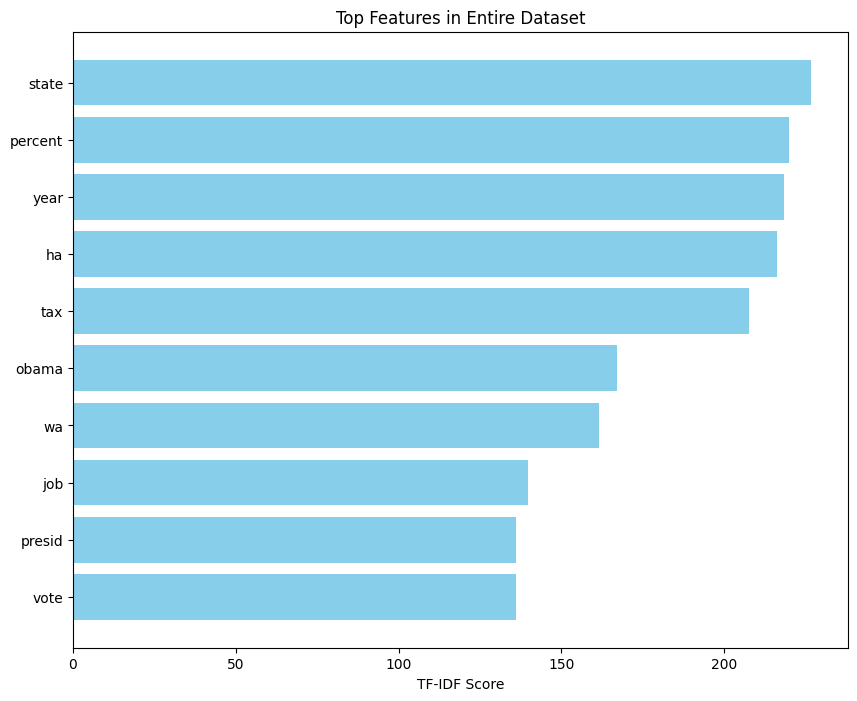

In [63]:
feature_scores = extract_feature_scores(tfidf_vectorizer, liar_df_tfidf_matrix)
plot_top_features(feature_scores, category_name='Entire Dataset')

These most frequent terms clearly indicate the domain of the text we're working with - politics. This feature matrix can later be used in training our ML models.

### 4.2. N-grams

N-grams is a convenient way to start looking for patterns in text. They can capture a sequence of words, that have more significance in the text, and combined with other filtering technics can demonstrate interesting results. For example, in case of political texts, if a certain sequence of words persist in all the analyzed texts and has a significantly larger occurrence - it may be a sign of a bias.

In this section we will analyze each slice of our dataset, create a filtered by POS tagging dictionary of ngrams and visualize the results.

In [158]:
def create_ngram_dict(texts, n=2, stop_words=additional_stop_words, occurrence=10, valid_pos_tags={'NN', 'NNP', 'NNS', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS', 'MD', 'VB', 'VBP', 'VBD', 'VBG', 'VBN', 'VBZ'}):
    """
    Create a dictionary of n-grams for a given list of texts.

    Parameters:
    - texts: a list of strings
    - n: quantity of words in n-grams
    - stop_words: words to exclude from n-grams
    - occurrence: how many times the n-gram occurs in texts
    - valid_pos_tags: pos tags to include in n-gram dictionary

    Returns:
    - dict: A dictionary of n-grams with occurrences.
    """
    
    words = word_tokenize(" ".join(texts))
    n_grams = list(ngrams(words, n))

    filtered_ngrams = Counter()

    for gram in n_grams:
        # Check for stopwords or digits in the n-gram
        if any(stemmer.stem(word) in stop_words or word.isdigit() or len(word) == 0 for word in gram):
            continue

        pos_tags = pos_tag(gram)

        if all(tag in valid_pos_tags for _, tag in pos_tags):
            filtered_ngrams[' '.join(gram)] += 1

    filtered_ngrams = {ngram: count for ngram, count in filtered_ngrams.items() if count >= occurrence}

    return filtered_ngrams

def generate_wordcloud(filtered_ngrams_counts):
  # Create a word cloud based on the word frequencies
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(filtered_ngrams_counts)

  # Display the word cloud
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

In [58]:
liar_df_texts = [get_clean_text(text) for text in liar_df['Statement']]
false_df_texts = [get_clean_text(text) for text in false_df['Statement']]
half_true_df_texts = [get_clean_text(text) for text in half_true_df['Statement']]
mostly_true_df_texts = [get_clean_text(text) for text in mostly_true_df['Statement']]
pants_on_fire_df_texts = [get_clean_text(text) for text in pants_on_fire_df['Statement']]
true_df_texts = [get_clean_text(text) for text in true_df['Statement']]
barely_true_df_texts = [get_clean_text(text) for text in barely_true_df['Statement']]

In [59]:
liar_texts_ngrams = create_ngram_dict(liar_df_texts)
false_df_texts_ngrams = create_ngram_dict(false_df_texts)
half_true_df_texts_ngrams = create_ngram_dict(half_true_df_texts)
mostly_true_df_texts_ngrams = create_ngram_dict(mostly_true_df_texts)
pants_on_fire_df_texts_ngrams = create_ngram_dict(pants_on_fire_df_texts)
true_df_texts_ngrams = create_ngram_dict(true_df_texts)
barely_true_df_texts_ngrams = create_ngram_dict(barely_true_df_texts)

Let us explore the ngrams in the entire dataset and in False / True slices.

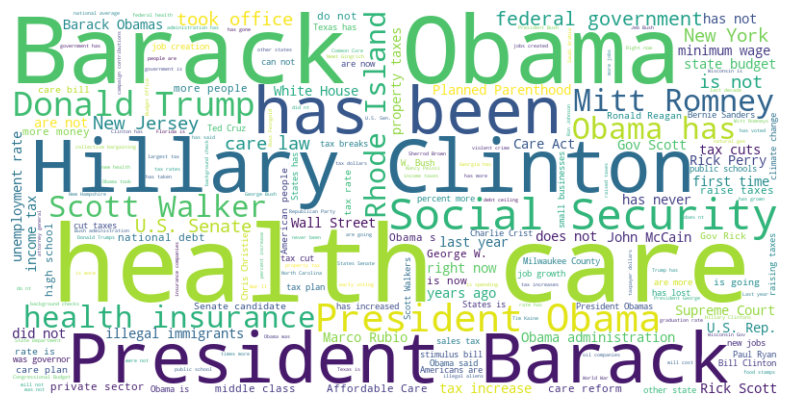

In [85]:
generate_wordcloud(liar_texts_ngrams)

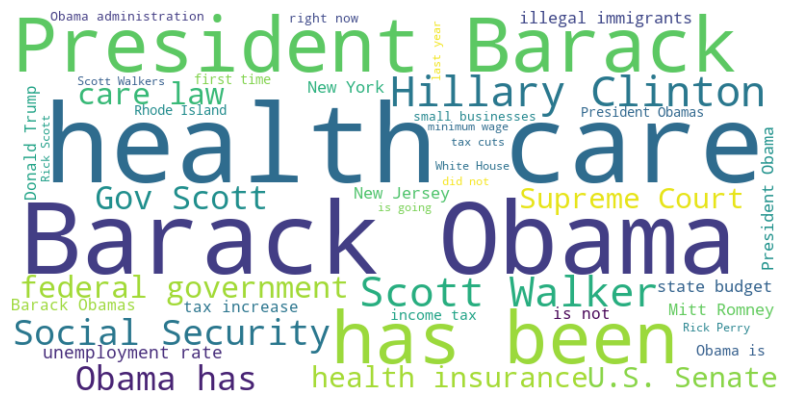

In [86]:
generate_wordcloud(false_df_texts_ngrams)

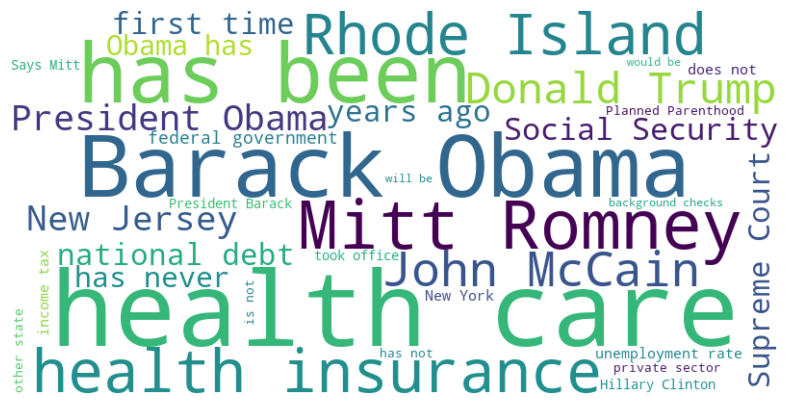

In [71]:
generate_wordcloud(true_df_texts_ngrams)

It is hard to make any conclusions or find any patterns in these visualizations, however we have one more method to look at - Named Entity Recognition.

### 4.3. Named Entity Recognition

Another approach that we will take, in a way an step further of the simply creating a bag-of-words method, is **Named Entity Recognition (NER)**. It is a NLP technique that involves the identification and classification of entities (real-world objects) in text into predefined categories such as person names, organizations, locations, medical codes, time expressions, monetary values, percentages, etc. The goal of NER is to extract structured information from unstructured text data. Since political fake news is a very contextual phenomena, NER approach might be helpful in identifying key figures and places than might be meaningful. There are some challenges with this approach:

- Ambiguity: Some words may have multiple meanings, making it challenging to determine the correct entity type.
- Variability: Entities may be expressed in various forms and styles, making it necessary to account for variations.
- Context Dependency: The context in which an entity appears may influence its type. For example, "Apple" could refer to the company or the fruit.

Let us define a function to extract entities from our texts and a function to visualize the results. The latter function will be able to display either just occurrences of NERs or occurrences ratio to the total word count.

In [70]:
def extract_entities_from_articles(texts):
  # Initialize a Counter to store entity occurrences
  entity_counter = Counter()

  for text in texts:
    doc = nlp(text)

    for ent in doc.ents:
      entity_text = ent.text
      entity_label = ent.label_

      if entity_text not in entity_counter:
        entity_counter[entity_text] = {'occurrences': 0, 'label': entity_label}

      entity_counter[entity_text]['occurrences'] += 1

  # Convert the Counter to a dictionary for easy access
  return dict(entity_counter)


def display_ner(ner, filter_by=[], entities_to_display=20, total_word_count=0):
  """
  Create a plot of NERs for a given list

  Parameters:
  - ner: a list of NERs
  - filter_by: a list of POS tags to filter by
  - entities_to_display: how many entities should be displayed on a plot
  - total_word_count: total word count
  """
  if len(filter_by) > 0:
    ner = {entity: info for entity, info in ner.items() if info.get('label') in filter_by}

  sorted_entities = sorted(ner.items(), key=lambda x: x[1]['occurrences'], reverse=True)

  entities, occurrences = zip(*[(entity, info['occurrences']) for entity, info in sorted_entities])

  if total_word_count > 0:
    entities, occurrences = zip(*[(entity, info['occurrences']/total_word_count * 100) for entity, info in sorted_entities])

  # Filter the top entities to display
  entities = entities[:entities_to_display]
  occurrences = occurrences[:entities_to_display]

  plt.figure(figsize=(20, 6))
  plt.bar(entities, occurrences, color='skyblue')
  plt.xlabel('NER Entities')

  if total_word_count > 0:
    plt.ylabel('Occurrences ratio to the total word count')
  else:
    plt.ylabel('Occurrences')
    
  plt.title('Named Entity Recognition Entities and Occurrences')
  plt.xticks(rotation=45, ha='right')
  plt.show()


In [71]:
false_ner = extract_entities_from_articles(false_df_texts)
true_ner = extract_entities_from_articles(true_df_texts)
liar_df_ner = extract_entities_from_articles(liar_df_texts)

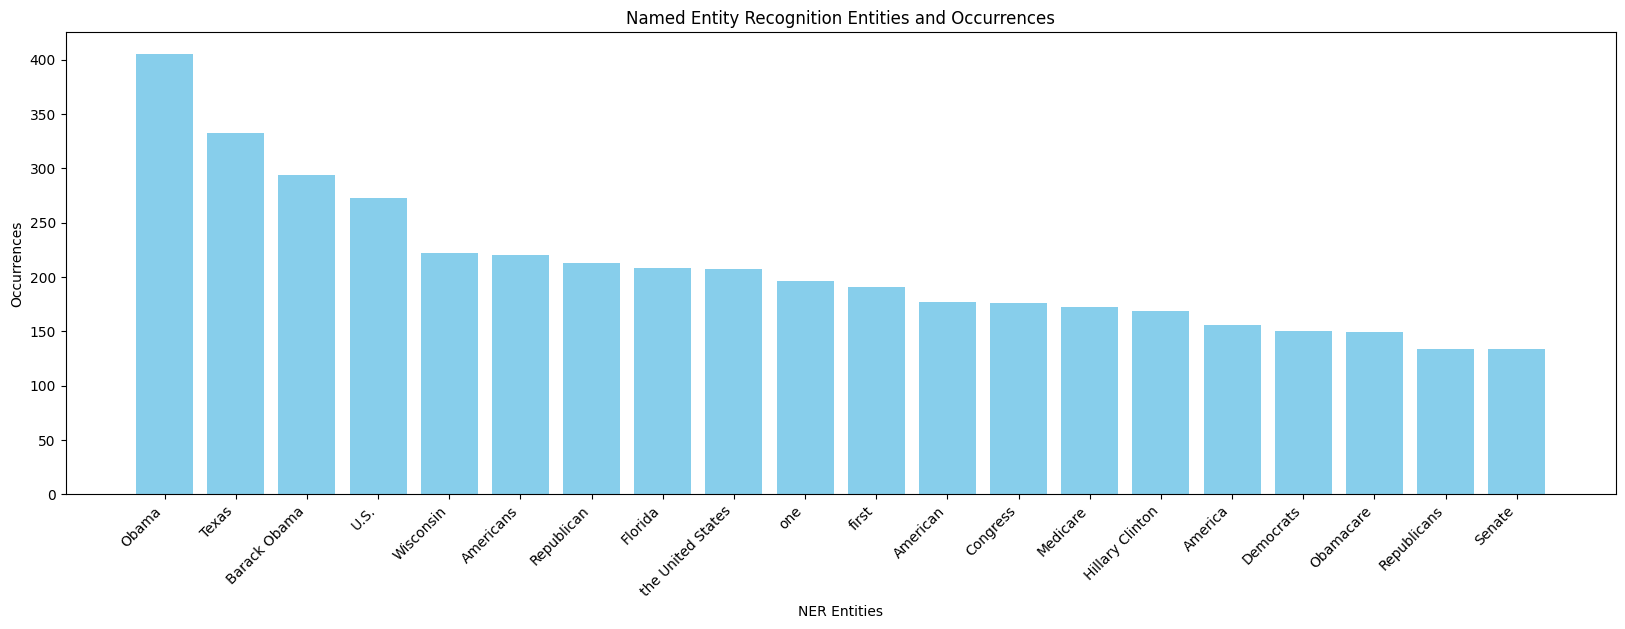

In [72]:
display_ner(liar_df_ner)

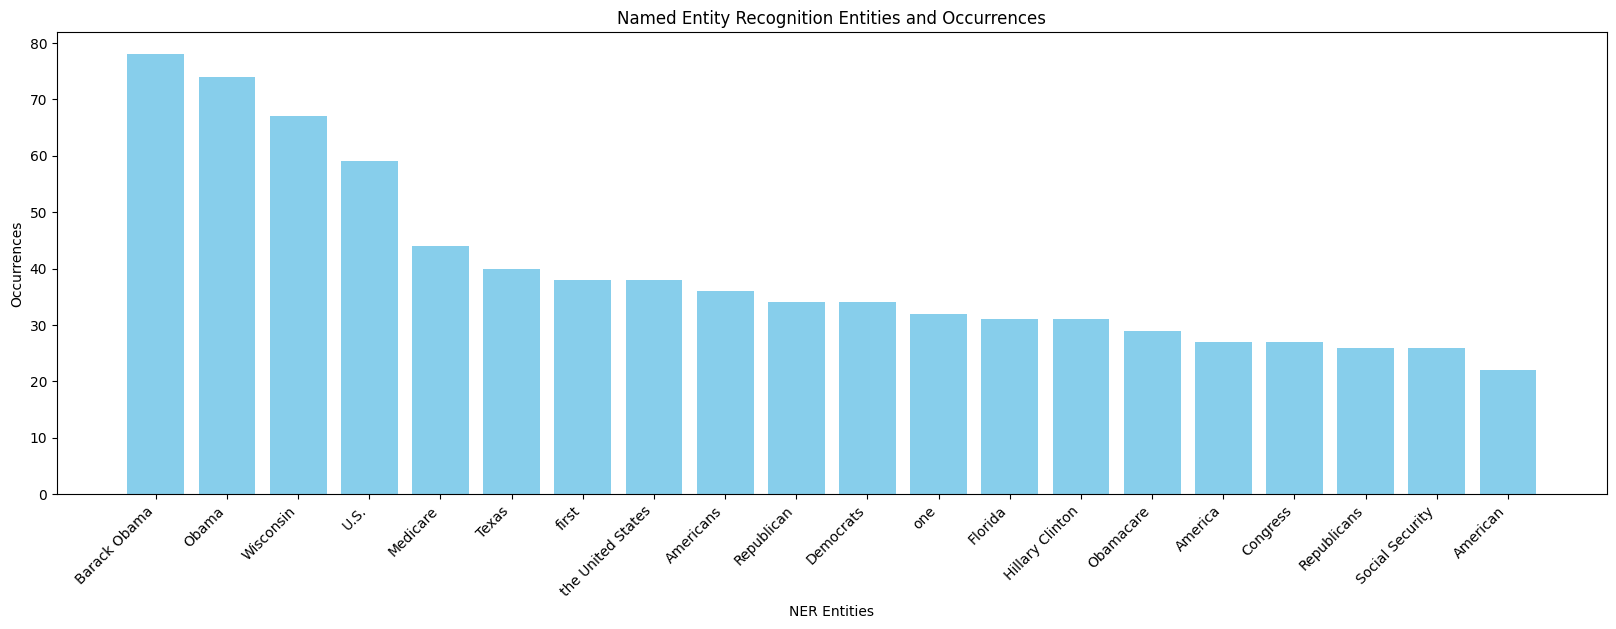

In [73]:
display_ner(false_ner)

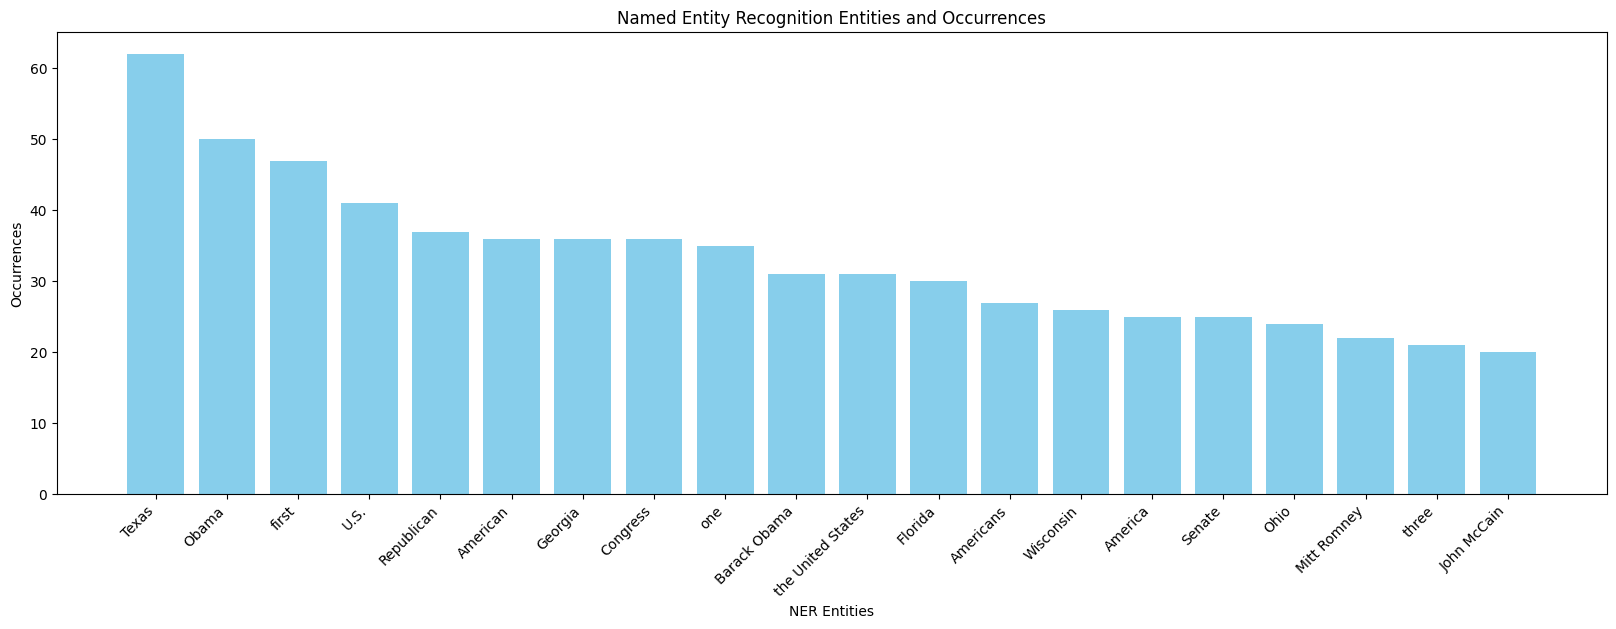

In [74]:
display_ner(true_ner)

The one interesting observation we can make from these plots: Barack Obama and Hillary Clinton are mentioned more in false news, however, this is not enough to make a distinction.

So far we have used 3 popular feature engineering technics, however we will use the TF-IDF as our main method, as it is suitable for capturing not only names, but the correlation between the frequency of a particular document to the whole corpus.

## 5. Experimenting with ML models

Now that we have decided on TF-IDF as our main feature - we can proceed with loading all the data, creating a pipeline and fitting our models.

In [161]:
# Reload liar_df
train_df = pd.read_csv("dataset/train-cleaned.csv")
test_df = pd.read_csv("dataset/test-cleaned.csv")
validation_df = pd.read_csv("dataset/valid-cleaned.csv")

In [162]:
X_train, y_train = train_df['Statement'].apply(preprocess), train_df['Label']
X_test, y_test = test_df['Statement'].apply(preprocess), test_df['Label']
X_validation, y_validation = validation_df['Statement'].apply(preprocess), validation_df['Label']

In [181]:
X_train

0        anni list polit group support third-trimest ab...
1        declin coal start start natur ga took start be...
2        hillari clinton agre john mccain `` vote give ...
3        health care reform legisl like mandat free sex...
4                         econom turnaround start end term
                               ...                        
10264    larger number shark attack florida case voter ...
10265        democrat becom parti atlanta metro area black
10266    altern social secur oper galveston counti texa...
10267            lift u.s. cuban embargo allow travel cuba
10268    depart veteran affair ha manual veteran stuff ...
Name: Statement, Length: 10269, dtype: object

In [182]:
y_train

0              false
1          half-true
2        mostly-true
3              false
4          half-true
            ...     
10264    mostly-true
10265    mostly-true
10266      half-true
10267          false
10268     pants-fire
Name: Label, Length: 10269, dtype: object

The problem we are trying to solve in this project is a multi-class text classification problem, thus we should choose ML models that support multiple labels. `LogisticRegression` in `scikit-learn` supports multi-class classification by default using a one-vs-rest scheme, but we want to explore `RandomForestClassifier` as well. Using ensemble method, we will combine these two models (with Random forest variations with different number of trees) using Voting Classifier.

In [192]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('feature_selection', SelectKBest(chi2, k=5000)),
    ('classifier', VotingClassifier(estimators=[
        ('lr', LogisticRegression(solver='newton-cg', random_state=42)),
        ('rf1', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('rf2', RandomForestClassifier(n_estimators=200, random_state=42)),
        ('rf3', RandomForestClassifier(n_estimators=300, random_state=42)),
        ('rf4', RandomForestClassifier(n_estimators=500, random_state=42)),
        ('rf5', RandomForestClassifier(n_estimators=800, random_state=42)),
    ], voting='soft'))
])

Now it is time to fit our models and predict.

In [193]:
pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
validation_predictions = pipeline.predict(X_validation)


Let us have a look at the scores.

In [194]:
print("Test Set Accuracy: ", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))

Test Set Accuracy:  0.23694466095089634
Classification Report:
               precision    recall  f1-score   support

 barely-true       0.30      0.18      0.23       214
       false       0.21      0.26      0.23       250
   half-true       0.23      0.30      0.26       267
 mostly-true       0.24      0.30      0.27       249
  pants-fire       0.29      0.05      0.09        92
        true       0.23      0.19      0.21       211

    accuracy                           0.24      1283
   macro avg       0.25      0.21      0.21      1283
weighted avg       0.24      0.24      0.23      1283



## 6. Evaluation and improvements

For the evaluation metrics we will use [this research](https://doi.org/10.1016/j.future.2020.11.022) as a guide, where the following metrics are suggested:

- **Accuracy:** the estimate of total number of correctly classified instances and is calculated using (Tp+Tn)(Tp+Fp+Fn+Tn)(Tp​+Fp​+Fn​+Tn​)(Tp​+Tn​)​;
  
- **Precision:** the percentage of relevant instances obtained from the total number of instances and is computed using Tp(Tp+Fp)(Tp​+Fp​)Tp​​;
  
- **Recall:** refers the percentage of relevant instances retrieved from the total number of relevant instances and computed using Tp(Tp+Fn)(Tp​+Fn​)Tp​​;
  
- **F1 Measure**: the harmonic average of precision and recall given by: F1 score = 2∗Precision∗Recall/Precision+Recall;

where
- Tp​ stands for True Positives
- TnTn​ stands for True Negatives
- FpFp​ stands for False Positives
- FnFn​ stands for False Negatives

Fake news classification is an important task to perform not only accurately, but with a high number of fake/real news classified correctly, as it has an impact on society. Thus, relying solely on the **accuracy** is not enough. In addition to the metrics above, we will also use **AUC** ("area under the curve"), which refers to the area under the ROC (receiver operating characteristic) curve. This curve is created by plotting the Tp rate against the Fp rate at different threshold settings. The AUC measures the area underneath this curve and provides an aggregated value for performance measuring within these thresholds. The value is between 0 and 1, and can be interpreted in the following way:

    AUC = 1: This indicates a perfect model; all positives are ranked above all negatives.
    0.5 < AUC < 1: This means the model is better than random guessing, with higher values indicating better classification performance.
    AUC = 0.5: This represents a model that has no discrimination capacity to distinguish between positive and negative classes.
    AUC < 0.5: This suggests that the model is worse than random guessing, which usually indicates that something is wrong with the model.

Since our dataset is imbalanced, as we saw in the EDA section, this metric is useful for us, as it won't be biased by the proportion of the test samples in positive class.

In [197]:
def print_metrics(pipeline, features, targets):
    print("Accuracy:", accuracy_score(targets, predictions))
    print("Precision (weighted):", precision_score(targets, predictions, average='weighted'))
    print("Recall (weighted):", recall_score(targets, predictions, average='weighted'))
    print("F1 Score (weighted):", f1_score(targets, predictions, average='weighted'))
    print("Classification Report:\n", classification_report(y_test, predictions))

    # For AUC, we need to binarize the labels and predict probabilities
    targets_binarized = label_binarize(targets, classes=np.unique(test_df['Label']))
    y_score = pipeline.predict_proba(features)
    # Calculate AUC for each class and average
    auc_scores = roc_auc_score(targets_binarized, y_score, multi_class='ovr', average='weighted')
    print("AUC (weighted):", auc_scores)

In [195]:
print_metrics(pipeline, X_test, y_test)

Accuracy: 0.23694466095089634
Precision (weighted): 0.2447805767397175
Recall (weighted): 0.23694466095089634
F1 Score (weighted): 0.2306146669162645
Classification Report:
               precision    recall  f1-score   support

 barely-true       0.30      0.18      0.23       214
       false       0.21      0.26      0.23       250
   half-true       0.23      0.30      0.26       267
 mostly-true       0.24      0.30      0.27       249
  pants-fire       0.29      0.05      0.09        92
        true       0.23      0.19      0.21       211

    accuracy                           0.24      1283
   macro avg       0.25      0.21      0.21      1283
weighted avg       0.24      0.24      0.23      1283

AUC (weighted): 0.5703223221694341


As we can see, there is a big room for improvement, however the AUC score can tell us that the model is actually better than random guessing. The most obvious problem that we might have is imbalance in classes, as was discovered in the Simple EDA section. When dealing with imbalanced classes, especially in a classification context where some classes have significantly more samples than others, it's important to implement strategies that can help the model learn effectively from all classes. The first thing that can be done is adjusting the weights inversely proportional to class frequencies or according to custom values through a `class_weight` parameter. This can help our model pay more attention to underrepresented classes. There are also different re-sampling technics that involve either oversampling the minority class, undersampling the majority class, or a combination of both. While this is not directly a part of a `scikit-learn` pipeline, we can use libraries like `imbalanced-learn` to apply these techniques before feeding data into our pipeline. Let us build a second pipeline that would incorporate these changes and focus only on `RandomForest` model variations.

In [200]:
pipeline_steps = [
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('feature_selection', SelectKBest(chi2, k=5000)),
    ('smote', SMOTE(random_state=42)),
    ('classifier', VotingClassifier(estimators=[
        ('rf1', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')),
        ('rf2', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')),
        ('rf3', RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')),
        ('rf4', RandomForestClassifier(n_estimators=500, random_state=42, class_weight='balanced')),
        ('rf5', RandomForestClassifier(n_estimators=800, random_state=42, class_weight='balanced')),
    ], voting='soft'))
]

pipeline2 = ImblearnPipeline(steps=pipeline_steps)

In [201]:
pipeline2.fit(X_train, y_train)
predictions = pipeline2.predict(X_test)
validation_predictions = pipeline2.predict(X_validation)

In [202]:
print_metrics(pipeline2, X_test, y_test)

Accuracy: 0.2377240841777085
Precision (weighted): 0.23523767505287524
Recall (weighted): 0.2377240841777085
F1 Score (weighted): 0.23528541349278265
Classification Report:
               precision    recall  f1-score   support

 barely-true       0.24      0.20      0.22       214
       false       0.25      0.26      0.26       250
   half-true       0.25      0.24      0.24       267
 mostly-true       0.24      0.28      0.26       249
  pants-fire       0.13      0.09      0.10        92
        true       0.24      0.27      0.25       211

    accuracy                           0.24      1283
   macro avg       0.22      0.22      0.22      1283
weighted avg       0.24      0.24      0.24      1283

AUC (weighted): 0.5649932969311715


As we can see, we have got even worse results for the AUC metic. It may be a sign that we either need more features to fir to, or deep networks to pick up the patterns more efficiently, however, this is out of scope for this project.

## 7. Conclusions

The goal of this project was to develop a pipeline for detecting fake news using various Natural Language Processing (NLP) techniques. By processing and analyzing textual data, we experimented with a model capable of distinguishing between true and false news statements. Throughout this process, we employed a comprehensive suite of tools and libraries, including Pandas, NumPy for data manipulation, NLTK and spaCy for text preprocessing, and scikit-learn for modeling and evaluation. Our approach involved careful data cleaning, feature extraction using TF-IDF vectorization, and feature selection, followed by the application of machine learning models like Random Forest and Logistic Regression to classify news articles.

We initiated the project by importing essential libraries and datasets, followed by data preprocessing to remove noise and standardize text data. Through exploratory data analysis, we gained insights into the datasets, which guided our preprocessing and modeling strategies. The implementation of TF-IDF for feature extraction and chi-squared tests for feature selection helped refine our data into a format suitable for modeling. We used machine learning pipelines to streamline the process of fitting models and making predictions, ensuring a robust and reproducible workflow. Evaluation metrics such as accuracy, precision, recall, F1 and AUC score provided a holistic view of model performance.

While the current project can serve as a starting point for fake news detection, several avenues for further work can enhance its effectiveness and applicability:

1. Exploring Advanced Models: Incorporating more sophisticated models such as deep learning architectures (e.g., LSTM, Transformers) could potentially improve detection accuracy by capturing more complex patterns in the data.
2. Expanding the Dataset: Utilizing a larger and more diverse dataset can help the model learn a broader range of linguistic cues associated with fake news, making it more robust across different contexts.
3. Multilingual and Multi-format Support: Extending the project to support multiple languages and data formats (e.g., videos, images) would increase its utility in today's global and multimedia landscape.

While the project demonstrates promising results, potential issues warrant attention:
1. Bias in Data: The inherent biases present in any dataset can influence model predictions, necessitating careful consideration and mitigation strategies to ensure fairness and accuracy.
2. Overfitting: The risk of overfitting, where the model performs well on training data but poorly on unseen data, underscores the need for rigorous validation and testing procedures.
3. Evolving Nature of Fake News: As the tactics employed in spreading fake news evolve, maintaining the model's relevance and effectiveness will require ongoing adjustments and updates to both the dataset and the modeling approach.

## 8. References

1. "Fake Detect: A Deep Learning Ensemble Model for Fake News Detection", Nida Aslam at el.Available at: https://doi.org/10.1155/2021/5557784
2. "An ensemble machine learning approach through effective feature extraction to classify fake news", Saqib Hakak at el. Available at: https://doi.org/10.1016/j.future.2020.11.022
3. "Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow", Aurélien Géron, 3rd Edition
4. Lectures by Akshi Kumar